# Generalized Position Verlet and Other Integrators for Hug

##### Hug Dynamic

Initial condition $(x_0, v_0)$ with $v_0 \perp \nabla f(x_0)$
$$
\begin{align}
    \dot{x} &= v \\
    \dot{v} &= F(x, v) \qquad \text{where} \qquad F(x, v) = - \frac{v^\top H(x)v}{\|\nabla f(x)\|} \widehat{\nabla f}(x)
\end{align}
$$


##### True Generalized Position Verlet (TGPV)
Implicit, second-order, sympletic, reversible. Requires initial condition $v_0 \perp \nabla f(x_0)$
$$
\begin{align}
    x_{n+1/2} &= x_n + \frac{\delta}{2}v_n \\
    v_{n + 1} &= v_n + \frac{\delta}{2}\left[F(x_{n+1/2}, v_n) + F(x_{n+1/2}, v_{n+1})\right] \\
    x_{n + 1} &= x_{n + 1/2} + \frac{\delta}{2}v_{n+1}
\end{align}
$$

##### Approximate Generalized Position Verlet (AGPV)
Explicit, non-reversible, approximately symplectic
$$
\begin{align}
    x_{n+1/2} &= x_n + \frac{\delta}{2}v_n \\
    v_{n + 1} &= v_n + \delta F(x_{n+1/2}, v_n) \\
    x_{n + 1} &= x_{n + 1/2} + \frac{\delta}{2}v_{n+1}
\end{align}
$$

##### Hug Integrator
$$
\begin{align}
    x_{n+1/2} &= x_n + \frac{\delta}{2}v_n \\
    v_{n + 1} &= v_n - \widehat{\nabla f}(x_{n + 1/2})\widehat{\nabla f}(x_{n + 1/2})^\top v_n \\
    x_{n + 1} &= x_{n + 1/2} + \frac{\delta}{2}v_{n+1}
\end{align}
$$

In [455]:
import autograd.numpy as anp
from autograd.numpy import zeros, array, eye, errstate, log, exp
from autograd.numpy.linalg import solve, norm, inv
from scipy.stats import multivariate_normal as MVN
from autograd import jacobian
from scipy.optimize import fsolve
import numpy as np
from numpy.linalg import det
from scipy.integrate import odeint, solve_ivp

from Manifolds.GeneralizedEllipse import GeneralizedEllipse

import sympy 
import matplotlib.pyplot as plt
from utils import quick_MVN_scatter

# Target Manifold and Density

In [332]:
# Manifold
μ = zeros(2)
Σ = array([[1.0, 0.9], [0.9, 2.0]])
target = MVN(μ, Σ)
f = lambda x: MVN(μ, Σ).logpdf(x)
grad_f = lambda x: - solve(Σ, x - μ)
hess_f = lambda x: - inv(Σ)
normalize = lambda x: x / norm(x)
z0 = log(0.01)
ellipse = GeneralizedEllipse(μ, Σ, exp(z0))

Jinv = array([[0,   0, 1, 0],
              [0,   0, 0, 1],
              [-1,  0, 0, 0],
              [0,  -1, 0, 0]])

# Posterior distribution
logprior = lambda x: MVN(zeros(2), eye(2)).logpdf(x)
def log_epanechnikov_kernel(xi, epsilon, f, z0):
    u = abs(f(xi) - z0)
    with errstate(divide='ignore'):
        return log((3*(1 - (u**2 / (epsilon**2))) / (4*epsilon)) * float(u <= epsilon))
logpost = lambda x: logprior(x) + log_epanechnikov_kernel(x, ϵ, f, z0)

# Helper Functions

In [562]:
def generate_x0v0():
    """Generates initial position x0 and velocity v0 such that
    the velocity is perpendicular to the gradient."""
    x0 = ellipse.sample()
    v0 = q.rvs()
    g0 = grad_f(x0)
    g0hat = g0 / norm(g0)
    v0perp = v0 - (g0hat @ v0) * g0hat
    v0perp = (v0perp / norm(v0perp)) * norm(v0)
    return np.concatenate((x0, v0perp))

def are_linearly_independent(v1, v2):
    matrix = np.vstack((v1, v2))
    _, indexes = sympy.Matrix(matrix).T.rref() 
    if len(indexes) == 2:
        print("linearly independant")
    else:
        print("linearly dependant")
        
def quadratic_formula(a, b, c):
    solution_positive = (-b + anp.sqrt(b**2 - 4*a*c)) / (2*a)
    solution_negative = (-b - anp.sqrt(b**2 - 4*a*c)) / (2*a)
    return solution_negative

def is_symmetric(integrator, x0v0):
    x1v1 = integrator(x0v0)
    x2v2 = np.concatenate((x1v1[:2], -x1v1[2:]))
    x3v3 = integrator(x2v2)
    return np.all(abs(np.concatenate((x3v3[:2], -x3v3[2:])) - x0v0) <= 1e-6)

def check_symplectic(integrator, x0v0, tol=1e-2):
    Jϕ = jacobian(integrator)(x0v0)
    return np.max(abs(Jϕ.T @ (Jinv @ Jϕ) - Jinv)) < tol

def rmse_integrator(integrator, N):
    mean_squared_error = 0.0
    for i in range(N):
        x0v0 = generate_x0v0()
        x1v1 = integrator(x0v0)
        mean_squared_error += (f(x0v0[:2]) - f(x1v1[:2]))**2 / N
    return np.sqrt(mean_squared_error)

def iterate_integrator(integrator, N, x0v0):
    points = x0v0
    current = x0v0
    N = 1000
    for i in range(N):
        current = integrator(current)
        points = np.vstack((points, current))
    return points

# True Generalized Position Verlet Integrator

In [341]:
def TGPV_integrator(xv):
    x, v = xv[:2], xv[2:]
    # half position step
    x = x + δ*v/2
    g = grad_f(x); gn = norm(g); ghat = g / gn;
    H = hess_f(x)
    a = v - ((δ/2)*(v@(H@v))*ghat/gn)
    b = - (δ/2)*ghat/gn
    p = a @ (H @ a)
    q = b @ (H @ a)
    r = b @ (H @ b)
    λ = quadratic_formula(a=r, b=(2*q-1), c=p)
    v = a + b*λ
    x = x + δ * v / 2
    return anp.concatenate((x, v))

In [568]:
#x0v0 = generate_x0v0()
x0v0 = np.concatenate((ellipse.sample(), q.rvs())) 
δ = 0.1
check_symplectic(TGPV_integrator, x0v0, tol=1e-1)

True

In [569]:
is_symmetric(TGPV_integrator, x0v0)

True

In [570]:
rmse_integrator(TGPV_integrator, 1000)

0.0007095860188051026

In [571]:
abs(det(jacobian(TGPV_integrator)(x0v0)))

0.9282586451365517

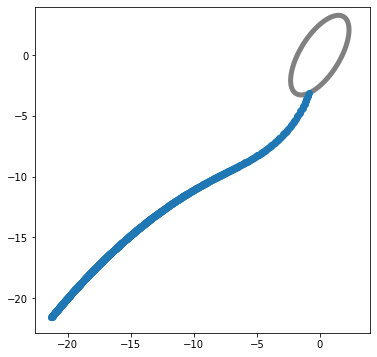

In [572]:
quick_MVN_scatter(iterate_integrator(TGPV_integrator, 100, x0v0)[:, :2], target, levels=[exp(z0)], figsize=(6, 6), xlims=(-4, 4), ylims=(-4, 4))

# Approximate Generalized Position Verlet Integrator

In [573]:
def AGPV_integrator(xv):
    x, v = xv[:2], xv[2:]
    # half position step
    x = x + δ*v/2
    g = grad_f(x); gn = norm(g); ghat = g / gn;
    H = hess_f(x)
    v = v - (δ/2)*(v @ (H @ v)) * ghat / gn
    x = x + δ * v / 2
    return anp.concatenate((x, v))

In [574]:
x0v0 = generate_x0v0()
δ = 0.1
check_symplectic(AGPV_integrator, x0v0, tol=1e-1)

True

In [575]:
is_symmetric(AGPV_integrator, x0v0)

False

In [576]:
rmse_integrator(AGPV_integrator, 200)

0.00672069183200621

In [577]:
abs(det(jacobian(AGPV_integrator)(x0v0)))

0.9351598402945444

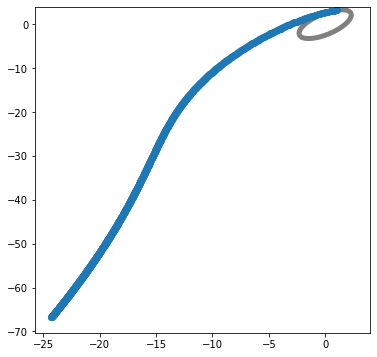

In [578]:
quick_MVN_scatter(iterate_integrator(AGPV_integrator, 100, x0v0)[:, :2], target, levels=[exp(z0)], figsize=(6, 6), xlims=(-4, 4), ylims=(-4, 4))

##### Hug Integrator

In [579]:
def hug_integrator(xv):
    x, v = xv[:2], xv[2:]
    # half position step
    x = x + δ*v/2
    g = grad_f(x); gn = norm(g); ghat = g / gn;
    H = hess_f(x)
    v = v - 2 * ghat * (ghat @ v)
    x = x + δ * v / 2
    return anp.concatenate((x, v))

In [605]:
x0v0 = np.concatenate((ellipse.sample(), q.rvs())) 
#x0v0 = generate_x0v0()
δ = 0.1
check_symplectic(hug_integrator, x0v0, tol=1e-1)

False

In [606]:
is_symmetric(hug_integrator, x0v0)

True

In [607]:
rmse_integrator(hug_integrator, 1000)

0.0006811763172778262

In [608]:
abs(det(jacobian(hug_integrator)(x0v0)))

0.9999999999999999

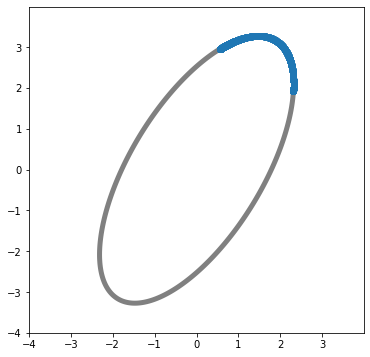

In [609]:
quick_MVN_scatter(iterate_integrator(hug_integrator, 100, x0v0)[:, :2], target, levels=[exp(z0)], figsize=(6, 6), xlims=(-4, 4), ylims=(-4, 4))

In [291]:
def derivative(t, xv):
    x, v = xv[:2], xv[2:]
    return np.concatenate((v, -v @ (hess_f(x) @ v) * grad_f(x) / norm(grad_f(x))**2))

In [230]:
def solve_ivp_integrator(x0v0):
    x1v1 = solve_ivp(derivative, (0.0, δ), x0v0).y[:, -1]
    return x1v1

In [317]:
N = 5000
δ = 0.1
times = np.linspace(0.0, N*δ, N+1)
x0v0 = generate_x0v0()

In [319]:
def derivative_odeint(xv, t):
    x, v = xv[:2], xv[2:]
    return np.concatenate((v, -v @ (hess_f(x) @ v) * grad_f(x) / norm(grad_f(x))**2))

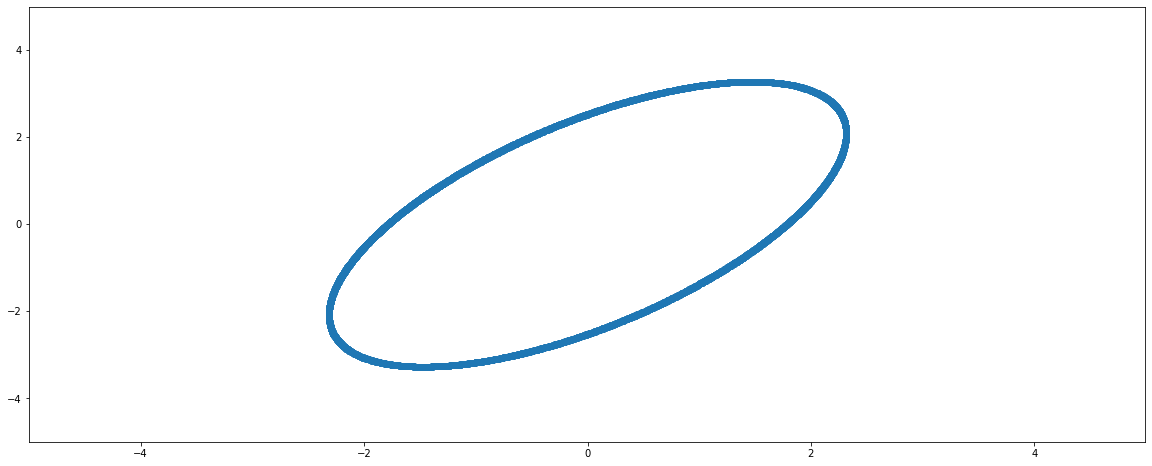

In [320]:
quick_MVN_scatter(odeint(derivative_odeint, x0v0, times)[:, :2], target, levels=[exp(z0)], step=0.01, xlims=[-5, 5], ylims=[-5, 5])

In [281]:
outRK45 = solve_ivp(derivative, (0.0, δ*N), x0v0, t_eval=times, method='RK45')

In [282]:
outDOP853 = solve_ivp(derivative, (0.0, δ*N), x0v0, t_eval=times, method='DOP853')

In [285]:
outRadau = solve_ivp(derivative, (0.0, δ*N), x0v0, t_eval=times, method='Radau')

In [287]:
outLSODA = solve_ivp(derivative, (0.0, δ*N), x0v0, t_eval=times, method='LSODA')

In [289]:
outBDF = solve_ivp(derivative, (0.0, δ*N), x0v0, t_eval=times, method='BDF')

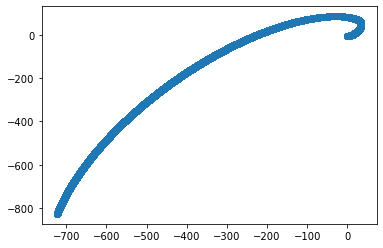

In [290]:
fig, ax = plt.subplots()
ax.scatter(*outBDF.y[:2, :])

In [187]:
x0v0 = anp.concatenate((ellipse.sample(), q.rvs()))
δ = 0.1

Jϕ = jacobian(gpv_hug_true_integrator3)(x0v0)

In [188]:
det(Jϕ)

0.762744417286637

In [189]:
((Jϕ.T @ Jinv) @ Jϕ).round(1)

array([[-0. ,  0.3,  0.9,  0.1],
       [-0.3,  0. ,  0.3,  0.8],
       [-0.9, -0.3, -0. , -0. ],
       [-0.1, -0.8,  0. , -0. ]])

In [212]:
is_symmetric(gpv_hug_true_integrator3, x0v0)

True

In [237]:
mse_integrator(gpv_hug_true_integrator3, 100)

(0.20449180425319582, 0.07414982235070858)

In [240]:
mse_integrator(lambda xv: np.concatenate(approx_hug_integrator(xv[:2], xv[2:], δ, grad_f)), 100)

(0.0014258932489684905, 5.964712984686008e-06)

In [241]:
mse_integrator(solve_ivp_integrator, 100)

(0.21179892072651996, 0.0823449124052227)

In [243]:
solve_ivp_integrator(x0v0)

array([-1.16592083, -3.3757553 ,  1.1826785 , -1.03954523])

In [244]:
gpv_hug_true_integrator3(x0v0)

array([-1.16612547, -3.37682104,  1.18018535, -1.03962921])

In [246]:
approx_hug_integrator(x0v0[:2], x0v0[2:], δ, grad_f)

(array([-1.20032115, -3.2366399 ]), array([0.49627183, 1.76399372]))

In [610]:
from scipy.stats import norm as ndist

In [662]:
σ = 0.1
μ = 0.0
ϵ = 0.01

In [663]:
from math import factorial

In [664]:
def cdf_approx(x, σ, terms=1):
    out = 0.5
    x = x / σ
    for k in range(terms):
        out += ((-1)**k) * (x**(2*k + 1)) / ((2**k) * factorial(k) * (2*k + 1) * np.sqrt(2*np.pi))
    return out

In [665]:
ndist.cdf(ϵ, scale=σ) - cdf_approx(ϵ, σ, terms=5)

-2.220446049250313e-16

In [666]:
ndist.cdf(-ϵ, scale=σ) - cdf_approx(-ϵ, σ, terms=5)

5.551115123125783e-17

In [667]:
ndist.cdf(ϵ, scale=σ) - ndist.cdf(-ϵ, scale=σ)

0.07965567455405798

In [668]:
(2 / np.sqrt(2*np.pi)) - 1 / (3*np.sqrt(2*np.pi))

0.6649038006690545

In [676]:
def prob_within(ϵ, σ, N):
    samples = ndist(scale=σ).rvs(N)
    return np.sum((-ϵ <= samples) & (samples <= ϵ)) / N

In [680]:
prob_within(0.1, 1.0, 1000000)

0.080003

In [681]:
np.sqrt(2 / np.pi) - (1 / (3*np.sqrt(2*np.pi)))

0.6649038006690545

In [684]:
(np.sqrt(2 * ϵ) / np.sqrt(np.pi)) - ϵ**(3/2) / (3*np.sqrt(2*np.pi))

0.07965547532015273

### Trying things out

In [704]:
from RWM import RWM

In [731]:
def check_idea():
    # Parameters
    y = 1
    σ = 0.1
    
    # Forward function and its gradient
    F    = lambda θ: θ[0] + θ[1]
    g    = lambda θ: np.array([1, 1])
    ghat = lambda θ: g(θ) / norm(g(θ))
    
    # Parameters
    μ0 = zeros(2)
    Σ0 = eye(2)
    Σ  = (σ**2) * eye(1)
    
    # Posterior stuff
    posterior_pdf    = lambda θ: MVN(μ0, Σ0).pdf(θ) * MVN(F(θ), Σ).pdf(y)
    posterior_logpdf = lambda θ: MVN(μ0, Σ0).logpdf(θ) + MVN(F(θ), Σ).logpdf(y)
    posterior_rvs    = lambda:   MVN(F(MVN(μ0, Σ0).rvs()), Σ).rvs()
    
    θ0 = MVN(μ0, Σ0).rvs()
    samples, acceptances = RWM(θ0, σ, 100000, posterior_logpdf)
    return samples, np.mean(acceptances)

In [732]:
samples, acc_prob = check_idea()

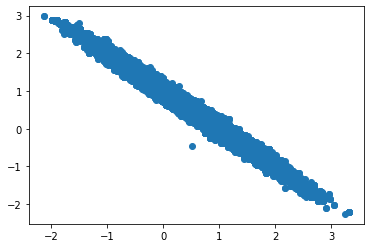

In [733]:
plt.scatter(*samples.T)

In [734]:
np.cov(samples.T)

array([[ 0.50360491, -0.49845374],
       [-0.49845374,  0.50317643]])

In [738]:
np.mean(samples, axis=0)

array([0.48464849, 0.51024671])

In [735]:
M = np.array([[1, 1]])

In [736]:
np.linalg.inv((1 / σ**2) * M.T @ M + np.eye(2))

array([[ 0.50248756, -0.49751244],
       [-0.49751244,  0.50248756]])

99.99999999999999